# Project Description
We will study a dataset containing hundreds of free advertisements for vehicles which are published on the Crankshaft website to determine which factors have the greatest effect size and influence on the price of a vehicle.

Loosly speaking the prcoess will be as follows
1. Data Investigation
2. Preprocessing
  - Missing data
  - Outliers
  - Inter-feature dependent categorical label accuracy
3. Investigate the typical ad lifecycle
4. Analyze which features effect price

# Summary of the Brief
The main questions are as follows:
- Describe the typical lifetime of an add
- Analyze the number of ads and the average price for each type of vehicle
- Using the two most popular vehicle types from Q2 analyze which numeric and categorical features impact their price most


# Overall Conclusion
**Preprocessing**
  - Overall post processing we lost only 11% of our data (closer to 12% when labels with fewer than 50 instances are trimmed) and almost all of the feature means and medians fell withing a +/-10% of each other
  - We need to investigate the missing paint color entries with Crankshaft seperatly
  - The vehicle type parameter of Crankshaft marketplace appears to allow users to assign an incorrect vehicle types - example there is no official Ford F150 being listed as a sedan. This field should be corrected and the list of types limited to official vehicle types associated with the users vehicle model

**Numeric Outlier detection**
 - Outliers were detected and removed in Price, Odometer, Days Listed, Vehicle Age using the IQR 1.5 rule
 - We used personal judgement to remove lower threshold outliers which consisted of zero odometer values for non-new vehicles and 1 USD vehicles. Both of which are caused by various reasons listed above but generally do not reflect the population trends so we removed them

**Categorical Outlier Detection**
  - When graphing categorical impact on features like Price and Days Listed we removed labels with fewer than 50 entries so as not to mis-interperet a skewed distribution which is not reflective of the population trends

**Typical Ad Lifetimes**
  - The average ad lifetime between all vehicle types is between 38 - 44 days
  - Buses take the longest time on average to sell
  - Days listed is right skewed for all types except bus

**Top Numeric Features for Days Listed**
- Overall no numeric features have a significant effect size or correlation to days_listed

**Top Categorical Fearures For Days Listed**
- Overall there is only a slight effect size on categorical features paint color, manufacturer, fuel type
- High p-value for fuel, transmission, and paint_color indicating potential random chance distributions

**Ad Lifetime Note**
  - There is a greater effect size when the dataset is split into shorter (Q1) and longer (Q3) ad lifetimes
  - However this was beyond the scope of the brief and the drew out the notebook so I removed it but it would be worth a second look

**Top Numeric Features for Price**
- We can see that numeric the feature which impact price for both Sedan and SUV vehicle are in descending order age, odometer, is_4wd, condition, cylinder have the highest correlation to vehicle price
  - The relationship is linear however the high pearson r is misleading as there is a high level of dispersion and heteroscedasticity along the x-axis meanign this featrure alone is not a good predictor of price above 15000 USD and vehicles older than 17 

**Top Categorical Features For Price**

**Transmission**
- Transmission has the highest F-stat: 1181.038
- The "other" label is the most expensive and a clear indicator of vehicle price
  - Unclear what the other category includes but as pickup trucks, coupes, and SUVs contribute the most it is to be a continuously variable transmission, semi-automatic, or dual-clutch transmissions
  - Vehicles with 'Other' transmission labels also have lower odometer counts
- Manual transmissions are the cheapest but also generally the oldest, and have the highest odometer readings

**Paint Color**
- Paint color is the least significant categorical predictor of price F-Stat: 111.367
- However it is clear that white, black, and yellow are the most expensive and most significant predictors of high price
- White black and yellow are usually younger too around 7.5 years while other colors vary from 8-12 years old
- Orange is also expensive however its sample size it too small to draw conclusions about population means
- A large subset of Trucks, SUVs, and Pickups in this dataset is whats driving the price of this vehicle color up

**Fuel Type**
- Fuel type is another significant predictor of price (F-stat: 837.583) with hybrid being the cheapest costing on average 7428 USD
- Deisel and Hybrid are the most statisically signficant opposing fuel types to predict price 
- Again we see trucks and pick ups driving the price of these vehicles up
- Interestingly we see a similar proportion of sedans in the top 3 vehicles of both types


**Manufacturer**
- Is the second weakest pridictor of price the large number of label groups means that the differences are less apparent 
- Within the group of manufacturers its clear Ram - a truck, pickup manufacturer is the most expensive while Honda is the cheapest
- Interestingly though Honda produces SUVs, Vans and some other large behicles but retains a relativly low price overall

#Next Steps
- Perform MLR using the strongest numeric and categorical feature for price
- The same can be done for days listed however, as mentioned through the notebook, predictions on the whole dataset are likely to be poor. Instead we should categorize the ad life into short/medium/long for statistically ignificant effect sizes to emerge from the features.


In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statisics PAckages
from scipy import stats
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ignore Warnings - Added Post Project To Avoide Future Warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Data Investigation

In [2]:
df = pd.read_csv("/datasets/vehicles_us.csv")
df.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28


In [3]:
pd.DataFrame({'Count': df.count(),
              '% Missing': round(df.isnull().sum() / len(df) * 100, 2),
              "Unique": df.nunique(),
              'Type':df.dtypes})

,Count,% Missing,Unique,Type
price,51525,0.00,3443,int64
model_year,47906,7.02,68,float64
model,51525,0.00,100,object
condition,51525,0.00,6,object
cylinders,46265,10.21,7,float64
fuel,51525,0.00,5,object
odometer,43633,15.32,17762,float64
transmission,51525,0.00,3,object
type,51525,0.00,13,object
paint_color,42258,17.99,12,object


In [4]:
df.describe()

,price,model_year,cylinders,odometer,is_4wd,days_listed
count,51525.000000,47906.000000,46265.000000,43633.000000,25572.0,51525.00000
mean,12132.464920,2009.750470,6.125235,115553.461738,1.0,39.55476
std,10040.803015,6.282065,1.660360,65094.611341,0.0,28.20427
min,1.000000,1908.000000,3.000000,0.000000,1.0,0.00000
25%,5000.000000,2006.000000,4.000000,70000.000000,1.0,19.00000
50%,9000.000000,2011.000000,6.000000,113000.000000,1.0,33.00000
75%,16839.000000,2014.000000,8.000000,155000.000000,1.0,53.00000
max,375000.000000,2019.000000,12.000000,990000.000000,1.0,271.00000


In [5]:
for col in df.select_dtypes(include='object'):
  if col != 'date_posted':
    print(df[col].unique())

['bmw x5' 'ford f-150' 'hyundai sonata' 'chrysler 200' 'chrysler 300'
 'toyota camry' 'honda pilot' 'kia sorento' 'chevrolet silverado 1500'
 'honda accord' 'ram 1500' 'gmc yukon' 'jeep cherokee'
 'chevrolet traverse' 'hyundai elantra' 'chevrolet tahoe' 'toyota rav4'
 'chevrolet silverado' 'jeep wrangler' 'chevrolet malibu' 'ford fusion se'
 'chevrolet impala' 'chevrolet corvette' 'jeep liberty' 'toyota camry le'
 'nissan altima' 'subaru outback' 'toyota highlander' 'dodge charger'
 'toyota tacoma' 'chevrolet equinox' 'nissan rogue'
 'mercedes-benz benze sprinter 2500' 'honda cr-v' 'jeep grand cherokee'
 'toyota 4runner' 'ford focus' 'honda civic' 'kia soul'
 'chevrolet colorado' 'ford f150 supercrew cab xlt'
 'chevrolet camaro lt coupe 2d' 'chevrolet cruze' 'ford mustang'
 'chevrolet silverado 3500hd' 'nissan frontier crew cab sv'
 'subaru impreza' 'jeep grand cherokee laredo' 'nissan versa'
 'ford f-250 sd' 'chevrolet silverado 1500 crew' 'ford f250 super duty'
 'chevrolet camaro' 'f

## Data Description
- 4 discrete ordinal Fatures Price, Model_Year, Cylinders, Days_listed
- 1 ordinal categorical feature Condition (convert to numeric) 
- 5 nominal categorical features Model, Fuel, Transmission, Type, Paint Color
- 1 binary feature is_4wd
- 1 date column (to be converted to datetime)

## Conclusion / Next Steps
- Investigate missing data model_year, cylinders, odometer, paint_color, is_4wd
- Investigate price, odometer, days listed, model_year (vehicle age) outliers
- Convert date_posted to datetime
- Lets parse the car manufacturer from the model column to create a broader category
- Lets also lowercase SUV in vehicle type



# 2(a). Pre-processing

## Parsing Manufacturer

In [6]:
df['manufacturer'] = df['model'].str.split(" ", 1, expand=True)[0]

- This will come in handy for further testing of features which impact vehicle price

## Investigating Missing Paint Color

In [7]:
round(df[df['paint_color'].isna()]['type'].value_counts() / df['type'].value_counts(), 2)

SUV            0.18
bus            0.21
convertible    0.17
coupe          0.18
hatchback      0.20
mini-van       0.17
offroad        0.17
other          0.18
pickup         0.19
sedan          0.18
truck          0.17
van            0.21
wagon          0.17
Name: type, dtype: float64

## Average Price Per Paint Color

In [8]:
print('Missing Paint Color Mean & Median Price:')
print(round(df[df['paint_color'].isna()]['price'].agg(['mean', 'median']), 2), '\n')
round(df.groupby('paint_color')['price'].agg(['mean', 'median']),2)

Missing Paint Color Mean & Median Price:
mean      12170.75
median     9400.00
Name: price, dtype: float64 



,mean,median
paint_color,,
black,13741.89,10995
blue,10269.71,7500
brown,10193.03,7277
custom,10030.10,7995
green,8426.98,5900
grey,11459.56,8500
orange,14654.35,15700
purple,6518.05,4997
red,11450.04,8701


## Number of Vehicle by Paint Color

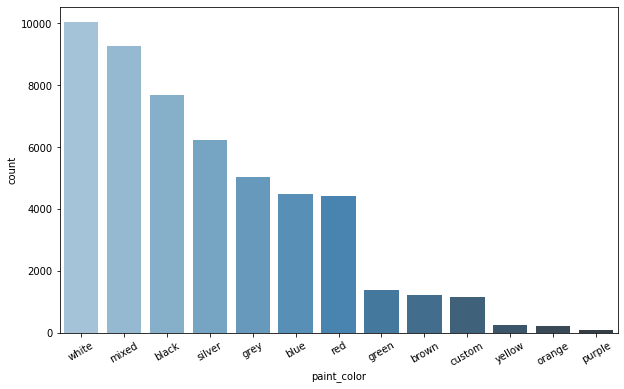

In [9]:
df['paint_color'].fillna('mixed', inplace=True)
plt.figure(figsize=(10, 6))
sns.countplot(x='paint_color', data=df, order = df['paint_color'].value_counts().index, palette='Blues_d')
plt.xticks(rotation=30)
plt.show()

- 18-21% of each vehicle type does not have its paint color listed 
- The average price among paint colors is ~10K USD (including the NA)
  - On average yellow is the most expensive and purple the cheaper 
- White and black are the two most popular vehicle colors with NA also on the top
- I chose to fillna with mixed as we can not be certain which colors they are and judging by the means and medians the effect size of paint_color to vehicle price does not seem too large to warrent a more thorough imputation
- However, a groupby object and mode would be an ideal solution to fill the NA values with the most common color for that vehicle type/model/price etc... I would research the online marketplace and discuss this with the data wrangler frist.

## Converting to Datetime
- extracting year, month, and day posted

In [10]:
df['date_posted'] = pd.to_datetime(df['date_posted'], format="%Y-%m-%d")
df['year_posted'] = df['date_posted'].dt.year
df['month_posted'] = df['date_posted'].dt.month
df['day_posted'] = df['date_posted'].dt.dayofweek

- We can create a vehicle age column once we will in missing model_year values
- We can see what is the most popular day, month, year for ads to be posted and taken down

## Investigating Missing is_4wd values

In [11]:
fourwd_na = df[df['is_4wd'].isna()]
fourwd_1 = df[df['is_4wd']==1]
print("Vehicle Types Without 4WD:")
print(fourwd_na['type'].value_counts())
print()
print('Vehicle Types With 4WD:')
print(fourwd_1['type'].value_counts())

Vehicle Types Without 4WD:
sedan          11591
SUV             3552
truck           2996
coupe           2227
pickup          1962
mini-van        1122
hatchback        887
van              593
wagon            468
convertible      393
other            130
bus               24
offroad            8
Name: type, dtype: int64

Vehicle Types With 4WD:
truck          9357
SUV            8853
pickup         5026
wagon          1073
sedan           563
offroad         206
hatchback       160
other           126
coupe            76
convertible      53
van              40
mini-van         39
Name: type, dtype: int64


In [12]:
df['is_4wd'].fillna(0, inplace=True)

- Filled with 0 as dispersion of missing values indicates its clearly a binary column 

## Standardizing Labels

In [13]:
df['type'] = df['type'].str.lower()
df['manufacturer'] = df['manufacturer'].replace('volkswagen', 'vw')

- volkswagen

## Filling NA Cylinder Count With Multi-Indexed Groupby Median

In [14]:
df['cylinders'] = df.groupby(['type', 'is_4wd'])['cylinders'].transform(lambda x: x.fillna(x.round().median()))
df['cylinders'] = df['cylinders'].astype(int)

- Median gives us the best estimates here

## Converting Condition Labels To Numeric

In [15]:
df['condition_numeric'] = df['condition'].replace({'new':5, 'like new':4, 'excellent':3, 'good':2, 'fair':1, 'salvage': 0})

- Per the brief - this also makes correlation more easily identified 
- pearson, kendall, tau or whichever is appropriate as apposed to ANOVA or T-test

## Filling NA Model Year with Groupby Mean
- Considered dropping the 7% of missing model year values
- However model year is highly correlated to price a target feature - lets keep it
- Price-Odometer groupby creates too many subsets so will group by price only and impute median model year

In [16]:
df['model_year'] = df.groupby('price')['model_year'].transform(lambda x: x.fillna(x.round().median()))
df = df[df['model_year'].notnull()].reset_index(drop=True)

## Creating Vehicle Age and Avg Annual Mileage Columns

In [17]:
df['vehicle_age'] = df['year_posted'] - df['model_year']
df['vehicle_age'] = df['vehicle_age'].astype(int)
df['model_year'] = df['model_year'].astype(int)

## Filling NA Odometer Values With Multi-Indexed Group By Mean
- Filling NA Odometer values with a groupby object of two of the most correlated features
  - model_year
  - condition

In [18]:
round(df['odometer'].corr(df['condition_numeric']), 2)

-0.3

In [19]:
print("Missing Means From Groupby Object:", df.groupby(['model_year', 'condition'])['odometer'].mean().isna().sum(),'\n')

display(df.groupby(['model_year', 'condition'])['odometer'].mean())
df['odometer'] = df.groupby(['model_year', 'condition'])['odometer'].transform(lambda x: x.fillna(x.round().mean()))

print("\nMissing Odometer Values After Fillna:", df['odometer'].isna().sum())

Missing Means From Groupby Object: 7 



model_year  condition
1908        excellent              NaN
            good         169328.000000
1929        good                   NaN
1936        excellent     30000.000000
1948        like new       4000.000000
                             ...      
2019        excellent     16854.328767
            good          21575.906977
            like new      14984.765432
            new            7030.875000
            salvage        9621.000000
Name: odometer, Length: 270, dtype: float64


Missing Odometer Values After Fillna: 7


- Lets drop those 7 NaN values now as we cant assertain what age they are or impute a logical average value and they would be dropped by the outlier trimming to come anyway

In [20]:
df = df[df['odometer'].notnull()]
df.reset_index(drop=True, inplace=True)

## Creating Annual Mileage Column
  - inf values from zero division caused by 0 odometers entries will be dropped during outlier trimming even if they are replaced by 0 as I intend to drop those rows from the dataset also

In [21]:
df['avg_annual_mileage'] = round((df['odometer'] / df['vehicle_age']), 2)

## Investigating The State Of The Dataset Post Processing

In [22]:
pd.DataFrame({'Count': df.count(),
              '% Missing': round(df.isnull().sum() / len(df) * 100, 2),
              "Unique": df.nunique(),
              'Type':df.dtypes})

,Count,% Missing,Unique,Type
price,51409,0.0,3334,int64
model_year,51409,0.0,67,int64
model,51409,0.0,100,object
condition,51409,0.0,6,object
cylinders,51409,0.0,7,int64
fuel,51409,0.0,5,object
odometer,51409,0.0,17847,float64
transmission,51409,0.0,3,object
type,51409,0.0,13,object
paint_color,51409,0.0,13,object


- No more missing values
- Note to investigate 0 values for odometer and days listed as well as low listed price during outlier investigation 

# 2(b). Outlier Investigation

## Boxplot and Histogram Function With Outlier Threshold Line
- Removing only upper limits will deal with lower values seperatly 

In [23]:
def distplots(df, feature, trigger, bins):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
  sns.boxplot(x=df[feature].dropna(), ax=ax1)
  sns.histplot(x=df[feature].dropna() , bins=bins, ax=ax2)

  ax1.set_title(f"Boxplot of {feature}", fontsize=16)
  ax2.set_title(f"Histogram of {feature}", fontsize=16)
  ax1.set_xlabel(feature, fontsize=14)
  ax2.set_xlabel(feature, fontsize=14)
  ax2.set_ylabel('Count', fontsize=14)
  # If trigger == True print line
  if trigger:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    ax2.axvline(ymin=0, ymax=1, x=(Q3 + 1.5 * IQR), color='red')
    ax2.text((Q3 + 1.5 * IQR) + (Q3 + 1.5 * IQR) / 10 , 1200, '1.5 * IQR', color='red')
    plt.show()
    print()
  # If triger == False do not print line
  if trigger:
    plt.show()
    print()

## Data Trimming Function

In [24]:
def trimmed_data(df, feature, bins):
  Q1 = df[feature].quantile(0.25)
  Q3 = df[feature].quantile(0.75)
  IQR = Q3 - Q1

  new = df[(df[feature] >= 0) & (df[feature] <= Q3 + 1.5 * IQR)]
  distplots(new, feature, False, bins)
  return new

## Odometer Distribution

Full Odometer Data Ditribution
Odometer Skew: 0.95


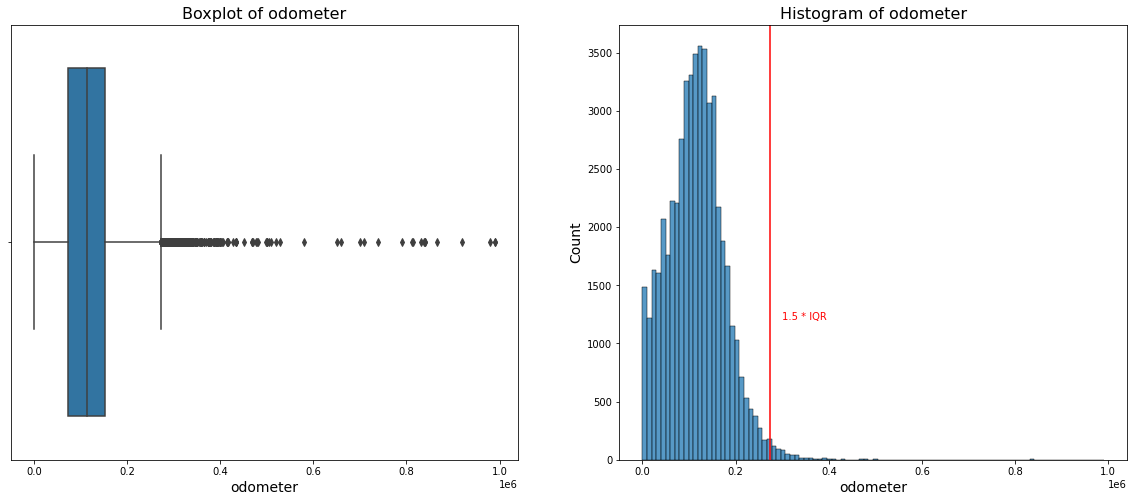



Trimmed Odometer Outlier Distribution
Trimmed Odometer Skew: 0.11


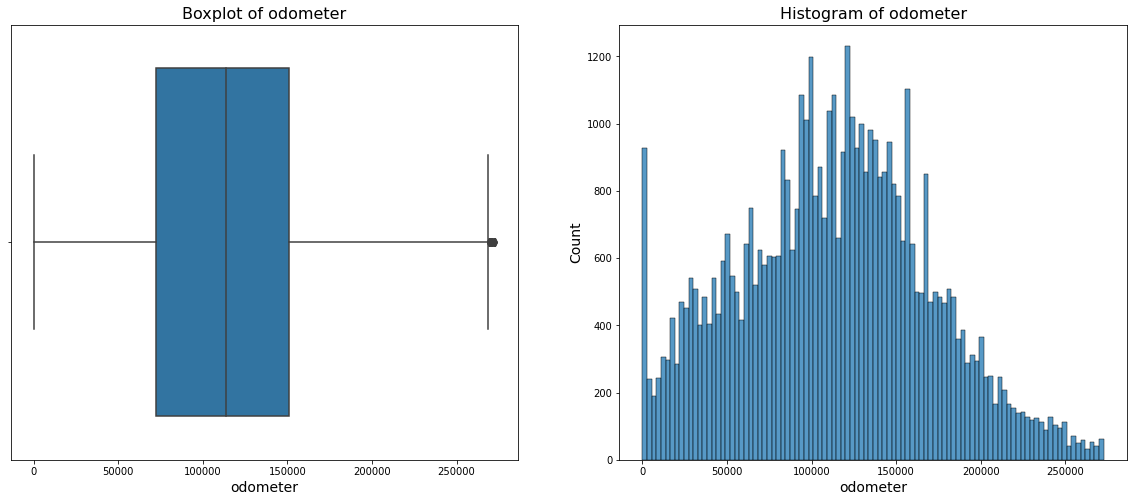

In [25]:
print('Full Odometer Data Ditribution')
print('Odometer Skew:', round(df['odometer'].skew(), 2))
distplots(df, 'odometer', True, 100)
print("Trimmed Odometer Outlier Distribution")
trimmed_df = trimmed_data(df, 'odometer', 100)
print('Trimmed Odometer Skew:', round(trimmed_df['odometer'].skew(),2))

In [26]:
round(trimmed_df[(trimmed_df['odometer'] == 0) & (trimmed_df['condition'] != 'new')].describe(), 2)

,price,model_year,cylinders,odometer,is_4wd,days_listed,year_posted,month_posted,day_posted,condition_numeric,vehicle_age,avg_annual_mileage
count,185.00,185.00,185.00,185.0,185.00,185.00,185.00,185.00,185.00,185.00,185.00,183.0
mean,9267.71,2006.69,5.82,0.0,0.30,38.79,2018.31,6.74,2.99,2.36,11.62,0.0
std,7449.30,10.51,1.74,0.0,0.46,27.31,0.47,3.57,1.96,0.64,10.61,0.0
min,1.00,1962.00,4.00,0.0,0.00,2.00,2018.00,1.00,0.00,0.00,0.00,0.0
25%,4900.00,2003.00,4.00,0.0,0.00,19.00,2018.00,3.00,1.00,2.00,4.00,0.0
50%,7950.00,2010.00,6.00,0.0,0.00,32.00,2018.00,7.00,3.00,2.00,9.00,0.0
75%,10888.00,2014.00,8.00,0.0,1.00,53.00,2019.00,10.00,5.00,3.00,15.00,0.0
max,49000.00,2018.00,10.00,0.0,1.00,177.00,2019.00,12.00,6.00,4.00,57.00,0.0


In [27]:
print('No Miles Vehicle Types:', '\n', round(trimmed_df[(trimmed_df['odometer'] == 0) & (trimmed_df['condition'] != 5)]['type'].value_counts(normalize=True), 2))
trimmed_df = trimmed_df[~(trimmed_df['odometer'] == 0) & (trimmed_df['condition'] != 'new')]

No Miles Vehicle Types: 
 sedan          0.33
truck          0.25
suv            0.14
wagon          0.10
pickup         0.06
coupe          0.05
hatchback      0.02
other          0.02
convertible    0.02
van            0.01
Name: type, dtype: float64



## Conclusion
- We have an almost peferfectly normal distribution post trimming with a skewness of 0.11. No doubt this trimming also had a reduction effect on other correlated features such as vehicle age
- We still have some lower threshold outliers particularly 0 values for non-new vehicles. Broadly speaking a couple of reasons these values could exist:
  - Most common would be online market tactics to draw in buyers by modifying the odometer or lying on the ad
  - Ex showroom models
  - Ex collectors
- Sedans, trucks, and SUVs are the most common poerhaps ex-showroom models
- However, as the cars seem to be older but cheaper we can expect that these ad posters are lying and as we are more interested in general trends I chose to remove them 



## Price Distribution

Full Data Ditribution
Price Skew: 3.59


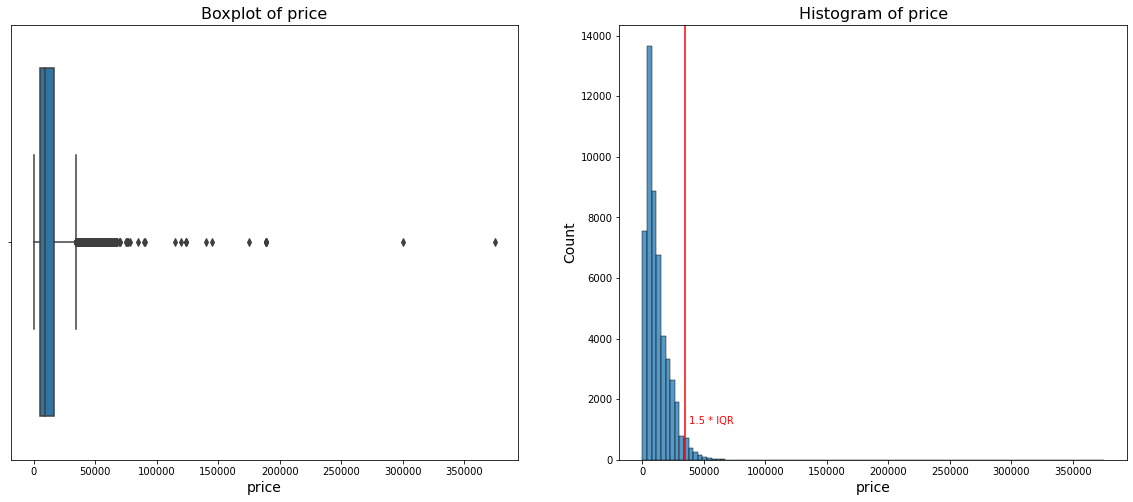



Trimmed Outlier Distribution
Trimmed Price Skew: 0.88


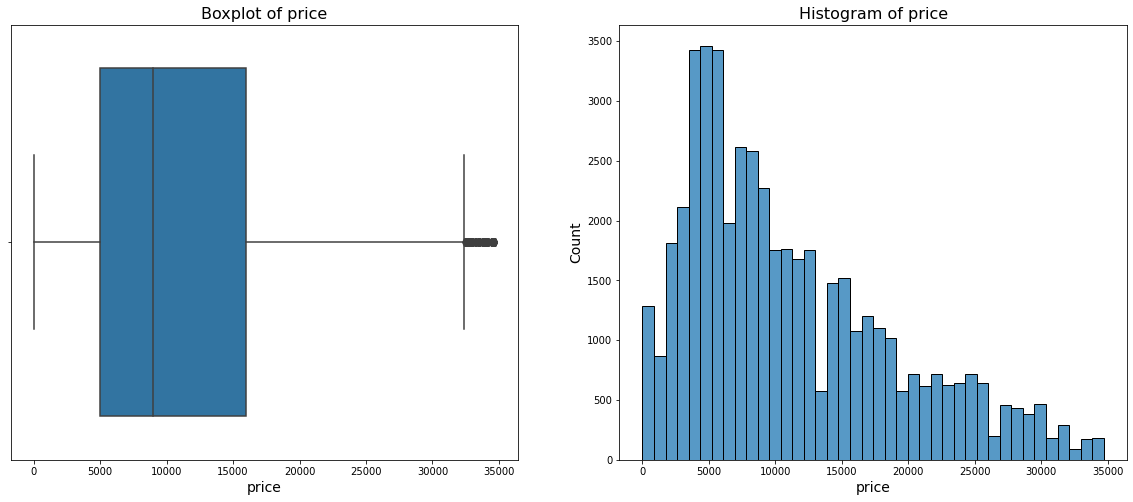

In [28]:
print('Full Data Ditribution')
print('Price Skew:', round(df['price'].skew(), 2))
distplots(df, "price", True, 100)
print("Trimmed Outlier Distribution")
trimmed_df = trimmed_data(trimmed_df, 'price', 40)
print('Trimmed Price Skew:', round(trimmed_df['price'].skew(),2))

- Data is still a little skewed but falls into the +/- 1 range
- Like odometer there is a small spike on vehicles near 0

In [29]:
print('Number Of Vehicles For 1 USD:', len(trimmed_df[trimmed_df['price'] == 1]))
print('Number Of Vehicles For Under 100 USD:', len(trimmed_df[trimmed_df['price'] < 100]), '\n')
round(trimmed_df[trimmed_df['price'] == 1].describe(), 2)

Number Of Vehicles For 1 USD: 793
Number Of Vehicles For Under 100 USD: 857 



,price,model_year,cylinders,odometer,is_4wd,days_listed,year_posted,month_posted,day_posted,condition_numeric,vehicle_age,avg_annual_mileage
count,793.0,793.00,793.00,793.00,793.00,793.00,793.00,793.00,793.00,793.00,793.00,793.00
mean,1.0,2015.79,7.76,43813.60,0.84,38.94,2018.30,6.71,3.06,2.99,2.51,inf
std,0.0,3.93,2.11,35466.53,0.37,27.97,0.46,3.52,2.05,0.31,3.98,NaN
min,1.0,1978.00,3.00,1.00,0.00,1.00,2018.00,1.00,0.00,1.00,0.00,0.08
25%,1.0,2015.00,6.00,17976.00,1.00,18.00,2018.00,3.00,1.00,3.00,0.00,15894.33
50%,1.0,2017.00,8.00,36927.00,1.00,33.00,2018.00,7.00,3.00,3.00,1.00,30911.50
75%,1.0,2018.00,10.00,59772.00,1.00,52.00,2019.00,10.00,5.00,3.00,3.00,NaN
max,1.0,2019.00,10.00,218000.00,1.00,213.00,2019.00,12.00,6.00,4.00,41.00,inf


In [30]:
print('No Miles Vehicle Types:', '\n', trimmed_df[trimmed_df['price'] == 1]['type'].value_counts(normalize=True))
trimmed_df = trimmed_df[trimmed_df['price'] != 1]

No Miles Vehicle Types: 
 truck          0.359395
suv            0.312736
sedan          0.177806
coupe          0.093317
van            0.020177
convertible    0.012610
hatchback      0.011349
pickup         0.008827
mini-van       0.002522
other          0.001261
Name: type, dtype: float64



## Conclusion
- Trmming reduced skew to within +/- 1
- Some reasons that come to mind for $1 price could be ad minimum's, online market tactics, an opt in for an auction
- 861 vehicles are listed for under 100 USD and 796 of them are 1 USD ads meaning we can cut those 1 USD ads 
- Most common condition for these vehicles is 3 / "excellent"
- Distribution for other numeric features such as days_listed and odometer seems reflective of the dataset
- It isnt likely to represent the general trends so I am removing them

## Days Listed Distribution

Full Data Ditribution
Days Listed Skew: 1.44


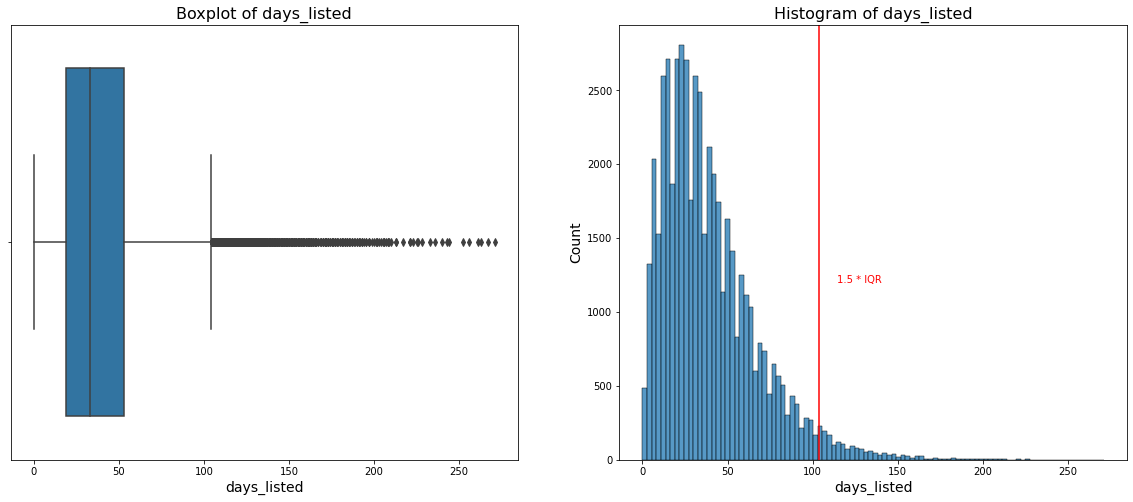



Trimmed Outlier Distribution
Trimmed Days Listed Skew: 0.74


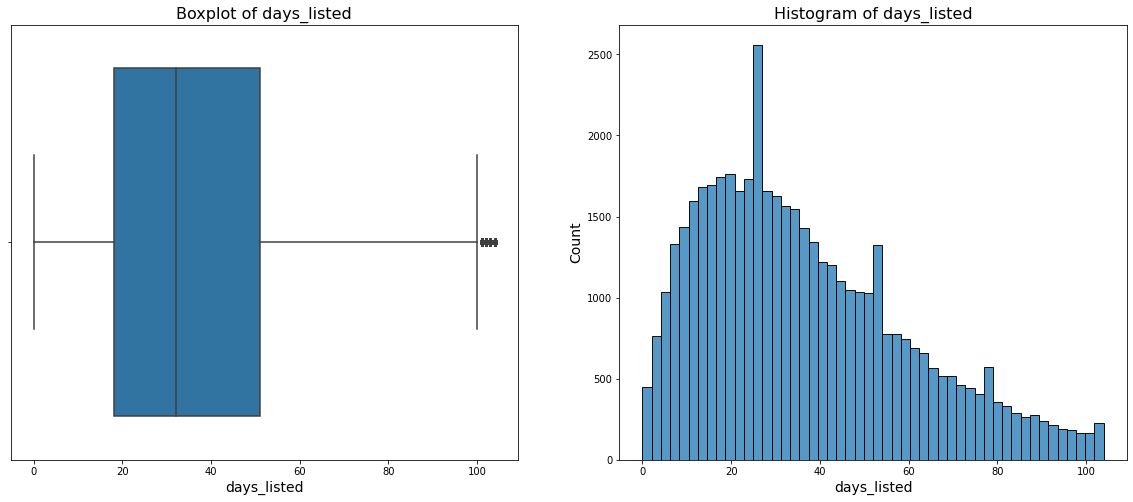

In [31]:
print('Full Data Ditribution')
print('Days Listed Skew:', round(df['days_listed'].skew(), 2))
distplots(df, "days_listed", True, 100)
print("Trimmed Outlier Distribution")
trimmed_df = trimmed_data(trimmed_df, 'days_listed', 50)
print('Trimmed Days Listed Skew:', round(trimmed_df['days_listed'].skew(),2))


## Conclusion
- Trimming reduced skew to 0.74
- As price and odometer have been trimmed the ad with fewer days listed and even 0 are now likely to indicate true type popularity so we will leave them in this feature and not trim any lower threshold outliers

## Vehicle Age Distribution

Full Data Ditribution
Odometer Skew: 1.75


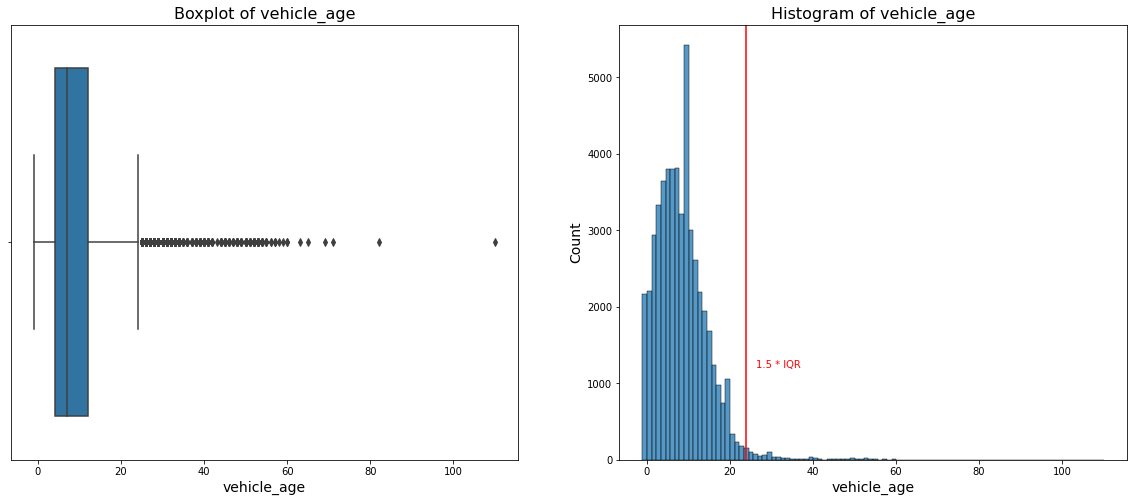



Trimmed Outlier Distribution
Trimmed Odometer Skew: 0.52


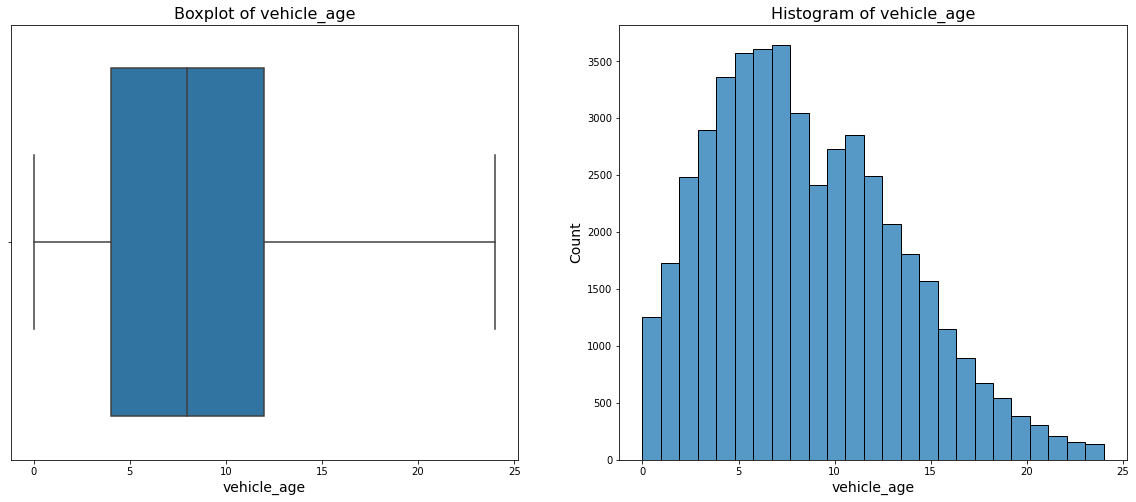

In [32]:
print('Full Data Ditribution')
print('Odometer Skew:', round(df['vehicle_age'].skew(),2))
distplots(df, 'vehicle_age', True, 100)
print("Trimmed Outlier Distribution")
trimmed_df = trimmed_data(trimmed_df, 'vehicle_age', 25)
print('Trimmed Odometer Skew:', round(trimmed_df['vehicle_age'].skew(),2))

## Conclusion 
- Trimming reduced skew to 0.52
- As with days listed 0 values here mean new or nearly new cars so we will leave them and not trim lower thrteshold outliers for this feature

## 2(c). Addressing bi-feature dependent categorical label accuracy
- Questions were excellently raised in our slack forum by Lucy Shulman (Practicum student) about the accuracy of model - vehicle type label accuracy
- Certain vehicles are being listed as types which the manufacturer does not produce, also the type label Wagon is somewhat ambiguous
- Before addressing lets perform a a one-way ANOVA test of the effect size of type on price


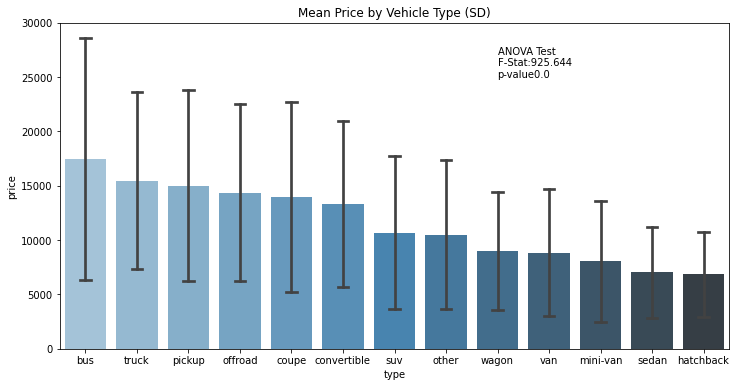

In [33]:
types = trimmed_df['type'].unique()
anovas = []

for typ in types:
  anovas.append(trimmed_df[trimmed_df['type'] == typ]['price'])

  f, p = stats.f_oneway(*anovas)

anovatextstr = f'ANOVA Test \nF-Stat:{f.round(3)}\np-value{p.round(3)}'

grp_order = trimmed_df.groupby('type').price.agg('mean').sort_values(ascending=False).index

viz = sns.barplot(x=trimmed_df['type'],y=trimmed_df['price'], estimator=np.mean, ci='sd', order =grp_order, capsize=0.2, palette="Blues_d")
viz.figure.set_size_inches(12,6)
viz.set_title("Mean Price by Vehicle Type (SD)")
plt.text(8, 25000, anovatextstr)
plt.show();

In [34]:
# for model in models:
#   if len(trimmed_df[trimmed_df['model'] == model]['type'].value_counts()) > 4:
#     print(model)

# trimmed_df[trimmed_df['model'] == 'toyota prius']['type'].value_counts()

- Vehicle type has a statisicaly signigicant effect on price so lets try to address some errors in a time efficient way
- After some research into model and type combinations I have made the conclusion that if the model has >4 types the vehicle type at index -1 and index -2 of a value_counts method appears to be consistently incorrect and the manufacturer does not produce such a model in the selected type so I will replaced it with the most common for all models in a loop
- I will replace just index -1 for now

In [35]:
models = trimmed_df['model'].unique()

for model in models:
  if len(trimmed_df[trimmed_df['model'] == model]['type'].value_counts()) > 4:
    most_common = (trimmed_df[trimmed_df['model'] == model]['type'].value_counts().index[0])
    least_common = (trimmed_df[trimmed_df['model'] == model]['type'].value_counts().index[-1])
    trimmed_df.loc[(trimmed_df['model'] == model) & (trimmed_df['type'] == least_common), 'type'] = most_common


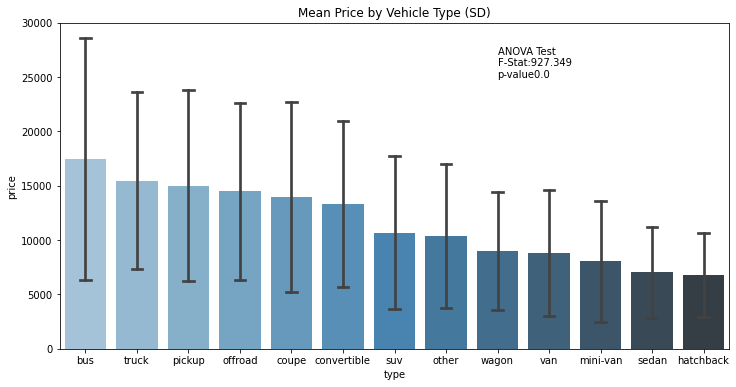

In [36]:
types = trimmed_df['type'].unique()
anovas = []

for typ in types:
  anovas.append(trimmed_df[trimmed_df['type'] == typ]['price'])

  f, p = stats.f_oneway(*anovas)

anovatextstr = f'ANOVA Test \nF-Stat:{f.round(3)}\np-value{p.round(3)}'

grp_order = trimmed_df.groupby('type').price.agg('mean').sort_values(ascending=False).index

viz = sns.barplot(x=trimmed_df['type'],y=trimmed_df['price'], estimator=np.mean, order=grp_order, ci='sd', capsize=0.2, palette="Blues_d")
viz.figure.set_size_inches(12,6)
viz.set_title("Mean Price by Vehicle Type (SD)")
plt.text(8, 25000, anovatextstr)
plt.show();

 ## Conclusion 
- This basic reassignment loop creates a very slight increase in effect size of the type feature but overall it remains largely the same
- Worth noting that post outlier trimming the F-stat for this feature was ~740 so there has been a significant impact on this features ability to predict price post trimming
- We can see type has a significant impact on price with large types (bus, truck, pickup) and special types (offroad, convertible) vehicles costing more than small and mid-sized types
- Grouping these types into Large, Special, Mid, and Small would produce a more correlated feature

# Investigate State of Data Post-processing

In [37]:
print("Data Lost During Trimming {:.0%}".format(round(1 - len(trimmed_df) / len(df), 2)))
print("New Data Shape {}".format(trimmed_df.shape))

Data Lost During Trimming 11%
New Data Shape (45949, 20)


- Only 11% of data lost post-processing
- Lets compare the means and median of pre and post processed data

In [38]:
df_pivot = df.pivot_table(index='type', values=['odometer', 'price', 'days_listed', 'vehicle_age'], aggfunc=['mean', 'median'], margins=True,margins_name='Overall_Avgs').round(2)
trimmed_pivot = trimmed_df.pivot_table(index='type', values=['odometer', 'price', 'days_listed', 'vehicle_age'], aggfunc=['mean', 'median'], margins=True,margins_name='Overall_Avgs').round(2)

diff_pivot = round(trimmed_pivot - df_pivot, 2)

diff_pivot

mean                    ...    median                    
             days_listed odometer    price  ...  odometer   price vehicle_age
type                                        ...                              
bus                -0.41  2825.26   310.24  ...  11640.66     0.0           0
convertible        -3.51  2168.11 -1246.30  ...   4957.00   745.0          -1
coupe              -3.35  1729.54  -309.84  ...   5695.00  1000.0          -1
hatchback          -2.61  -387.90   -51.41  ...    888.50     2.5           0
mini-van           -3.51 -1560.45   -68.41  ...   -181.46     2.5           0
offroad            -4.44 -4520.07   205.27  ...  -2777.00  1050.0          -1
other              -1.24  -225.52  -595.26  ...    340.00     0.0           0
pickup             -2.61  -890.72 -1017.40  ...   1322.53    -5.0           0
sedan              -2.92    96.24    61.21  ...    637.00     0.0           0
suv                -3.03  2376.95  -454.41  ...   1682.00     0.0           0
truck              -2.53  3165.17 -1236.71  ...   3580.47    -7.0           1
van                -4.10  3478.53 -1691.03  ...   8416.74  -190.0           0
wagon              -3.83  -745.84   -51.86  ...     96.23    50.0           0
Overall_Avgs       -2.88  1276.52  -710.96  ...   3249.70    -1.0           1

[14 rows x 8 columns]

- Neither the mean nor the median has changed much with most of the differences falling within +/- 10% margin
- Odometer values for most have dropped by between 1000-3000
- Price has increased for the most part
- Vehicle age and days_listed barely changed


# 3. Investigate Ad Count and Lifetime
- Study days listed feature
- Determine quick/long sale thresholds 
- Study numerical feature depedance in relation to thresholds
- Study categorical feature depedance in relation to thresholds

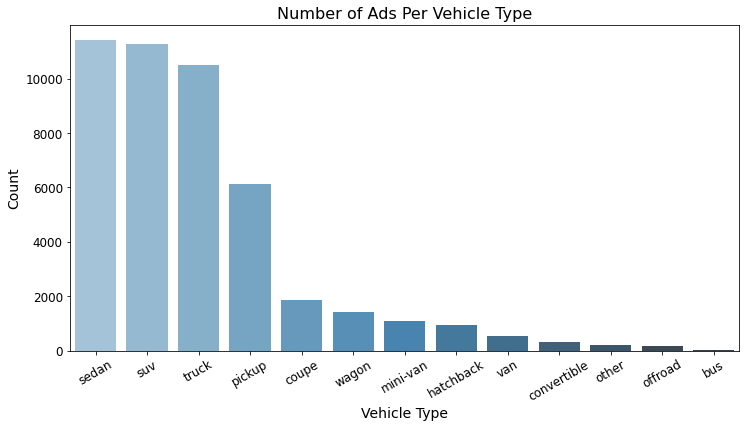

In [39]:
viz = sns.countplot(x='type',data=trimmed_df, order = trimmed_df['type'].value_counts().index, palette='Blues_d')
viz.figure.set_size_inches(12,6)
plt.xlabel('Vehicle Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12, rotation=30)
plt.yticks(fontsize=12)
plt.title("Number of Ads Per Vehicle Type", fontsize=16)
plt.show()

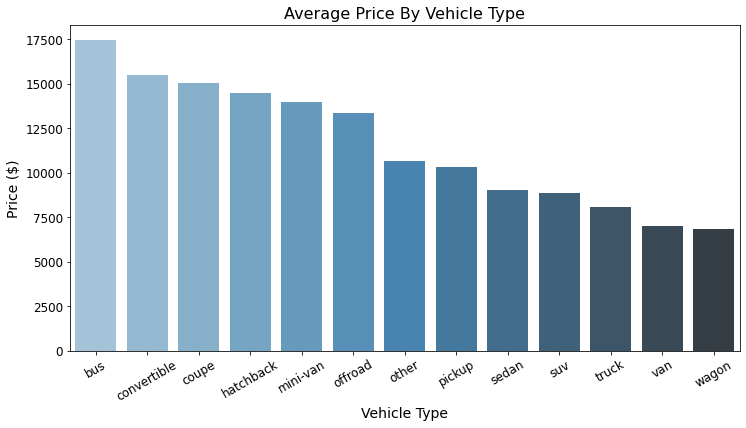

In [40]:
vehicle_price = trimmed_df.pivot_table(index='type', values='price', aggfunc=['count', 'mean'])
vehicle_price.columns = ['count', 'price']


viz = sns.barplot(x= vehicle_price.index, y=vehicle_price['price'].sort_values(ascending=False), palette='Blues_d')
viz.figure.set_size_inches(12,6)
plt.xlabel('Vehicle Type', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.xticks(fontsize=12, rotation=30)
plt.yticks(fontsize=12)
plt.title("Average Price By Vehicle Type", fontsize=16)
plt.show()

Index(['price', 'model_year', 'model', 'condition', 'cylinders', 'fuel',
       'odometer', 'transmission', 'type', 'paint_color', 'is_4wd',
       'date_posted', 'days_listed', 'manufacturer', 'year_posted',
       'month_posted', 'day_posted', 'condition_numeric', 'vehicle_age',
       'avg_annual_mileage'],
      dtype='object')
Trimmed Dataset Pearson Correlation: 45949


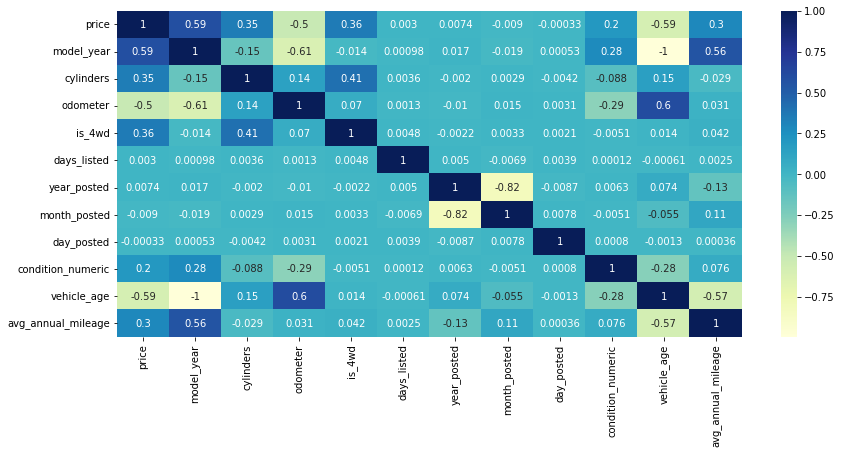

In [41]:
print(trimmed_df.columns)

print('Trimmed Dataset Pearson Correlation:', len(trimmed_df))
plt.figure(figsize=(14,6))
sns.heatmap(trimmed_df.corr(), annot=True, color='blue', cmap="YlGnBu")
plt.show()
print()

In [42]:
trimmed_df['days_listed'].describe()

count    45949.000000
mean        36.678013
std         23.206251
min          0.000000
25%         18.000000
50%         32.000000
75%         51.000000
max        104.000000
Name: days_listed, dtype: float64

In [43]:
round(trimmed_df.groupby('type')['days_listed'].agg(['mean', 'median']),2)

,mean,median
type,,
bus,43.09,40.0
convertible,35.70,31.0
coupe,36.00,32.0
hatchback,37.95,34.0
mini-van,35.90,32.0
offroad,35.96,29.5
other,36.94,32.0
pickup,36.67,32.0
sedan,36.53,32.0


## Conclusion
- The average ad time is 37 days
- The average time between all vehicle types is between 38 - 44 days
- Buses take the longest time on average to sell
- Days listed is right skewed for all types except bus
- No numeric features appear correlated to days_listed
- Lets try categorical


- Explored the differences between short and long ads intially but its beyond the ask of the he request of the brief so I commented it out

In [44]:
quick_sale = trimmed_df['days_listed'].quantile(0.25)
long_sale = trimmed_df['days_listed'].quantile(0.75)


quicker = trimmed_df[trimmed_df['days_listed'] < quick_sale]
longer = trimmed_df[trimmed_df['days_listed'] > long_sale]

quicker_numeric = quicker.pivot_table(index='type', values=['price', 'odometer', 'vehicle_age', 'condition_numeric', 'is_4wd', 'cylinders'], aggfunc='mean')
longer_numeric = longer.pivot_table(index='type', values=['price', 'odometer', 'vehicle_age', 'condition_numeric', 'is_4wd', 'cylinders'], aggfunc='mean')

diff = (longer_numeric - quicker_numeric).round(2)
diff

# + longer 
# - quicker

,condition_numeric,cylinders,is_4wd,odometer,price,vehicle_age
type,,,,,,
bus,0.08,0.17,0.00,-120875.34,9423.00,-3.08
convertible,-0.22,-0.35,0.08,14499.51,-608.43,-0.30
coupe,0.03,0.07,0.00,-400.00,-263.31,0.40
hatchback,-0.02,0.04,0.01,-2010.90,-24.73,-0.39
mini-van,0.04,0.05,0.00,-3414.65,298.73,-0.28
offroad,-0.12,0.03,0.02,-1913.24,239.80,-0.32
other,0.01,-0.16,0.06,-6746.17,-468.19,-1.01
pickup,0.02,0.03,0.01,-550.49,254.47,-0.24
sedan,-0.01,-0.04,-0.01,-85.48,67.41,0.02


## Numeric Feature Conclusion
Short Ad Life Significant Features:
- Odometer is significantly lower
- Vehicles are typically older
- Price varies by type
   - buses, mini-van, offroad, pickup, truck, sedan, van - tend to be more expensive and most of are correlated to slightly younger vehicle as well (excpet buses which tend to be much older)
   - convertible, coupe, hatchback, other, SUV, wagons - tend to be cheaper and slightly older
   - More convertibles and other tend to be 2 wheel drive
- **Longer sales are converse of points listed*


## Trimming Categorical Labels
#### Dropping labels with less than 50 instances

In [45]:
def final_trim(df, col_a): 
  counts = trimmed_df[col_a].value_counts()
  clean_df = trimmed_df[~trimmed_df[col_a].isin(counts[counts < 50].index)]
  return clean_df

clean_df = final_trim(trimmed_df, 'transmission')
clean_df = final_trim(clean_df, 'paint_color')
clean_df = final_trim(clean_df, 'manufacturer')
clean_df = final_trim(clean_df, 'fuel')
round(len(df) /len(clean_df) - 1, 4)

0.1189

## Further processing trimmed_df
- Merge the functions below 




In [46]:
# quicker = clean_df[clean_df['days_listed'] < quick_sale]
# longer = clean_df[clean_df['days_listed'] > long_sale]

In [47]:
def boxplots(df, col_a, col_b, title, label, bins):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
  sns.boxplot(x=df[col_a], y=df[col_b], ax=ax1)
  labels = df[col_a].unique()
  for l in labels:
    sns.distplot(x=df[df[col_a] == l][col_b], bins=bins, ax=ax2)
    plt.legend(labels)

  ax1.set_title(f"Boxplot of {col_a}", fontsize=16)
  ax2.set_title(f"Histogram of {col_a}", fontsize=16)
  ax1.set_xlabel(col_a, fontsize=14)
  if len(df[col_a].unique()) > 5:
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, horizontalalignment='center')
  else:
    ax2.set_xlabel(col_b, fontsize=14)
    ax2.set_ylabel('Density', fontsize=14)
    plt.show()
    print()

In [48]:
def anova(df, col_a, col_b, title):
  types = df[col_a].unique()
  anovas = []

  for typ in types:
    anovas.append(df[df[col_a] == typ][col_b])
  
    f, p = stats.f_oneway(*anovas)

  
  anovatextstr = f'ANOVA Test \nF-Stat:{f.round(3)}\np-value{p.round(3)}'
  print(anovatextstr,'\n')
  return boxplots(df, col_a, col_b, title,  'abc', 25)

ANOVA Test 
F-Stat:0.496
p-value0.609 



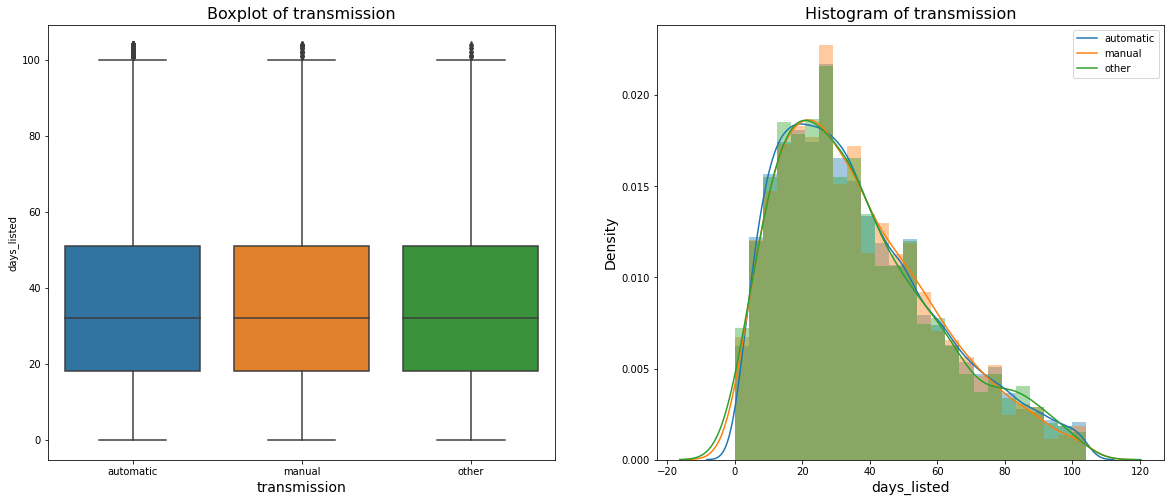

In [49]:
anova(clean_df, 'transmission', 'days_listed', 'Days Listed By Transmission Type')

## Conclusion
- Relativly even distributions among the transmissions types 
-  Manual and automatic transmission distributions closely mirror each other but automatic transmission tends to sell the quicker overall while Other transmission type takes slightly longer having a slight peak around 80+ 


ANOVA Test 
F-Stat:1.34
p-value0.188 



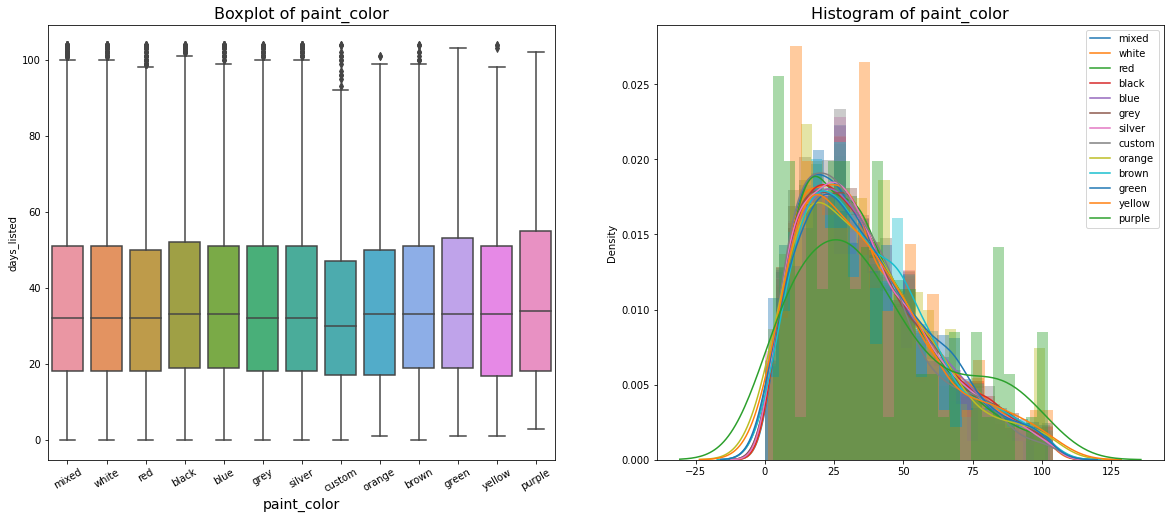

In [50]:
anova(clean_df, 'paint_color', 'days_listed', 'Days Listed By Paint Color Type')

## Conclusion





-
-
-
-
- Yellow and purple have the most opposing distributions among short ad lifes
- Purple peaks around 6 days days trailing off with another peak around 16 days and most yellow cars are sold 12 days mark in the short ad life category
- However other factors such as price and odometer must play an important factor as both seem to take longer to sell in the long ad life grouping
- All other color to days listed distributions appear to relfect one another
- Though paint color appears to be more influencial in shorter ad lifes
 

ANOVA Test 
F-Stat:1.181
p-value0.315 



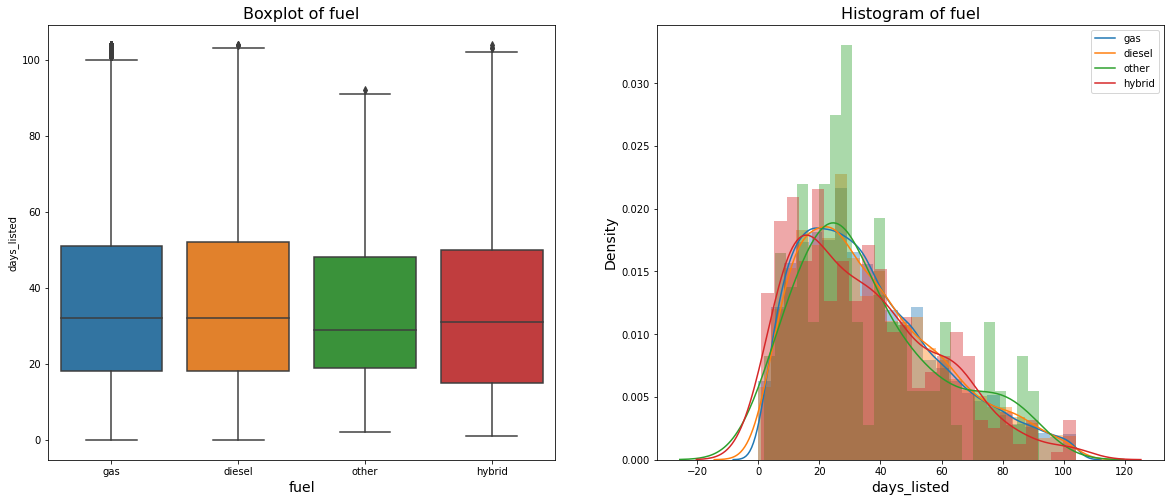

In [51]:
anova(clean_df, 'fuel', 'days_listed', 'Days Listed By Fuel Type')

# Conclusion

-
-
-
-
-- Fuel type doesnt appear to play a major factor in ad life time for shorter ad-lifetimes
- Other fuel types appear to take longer to sell overall in the long ad life grouping
- Consumers care less about fuel type at cheaper prices

ANOVA Test 
F-Stat:1.502
p-value0.084 



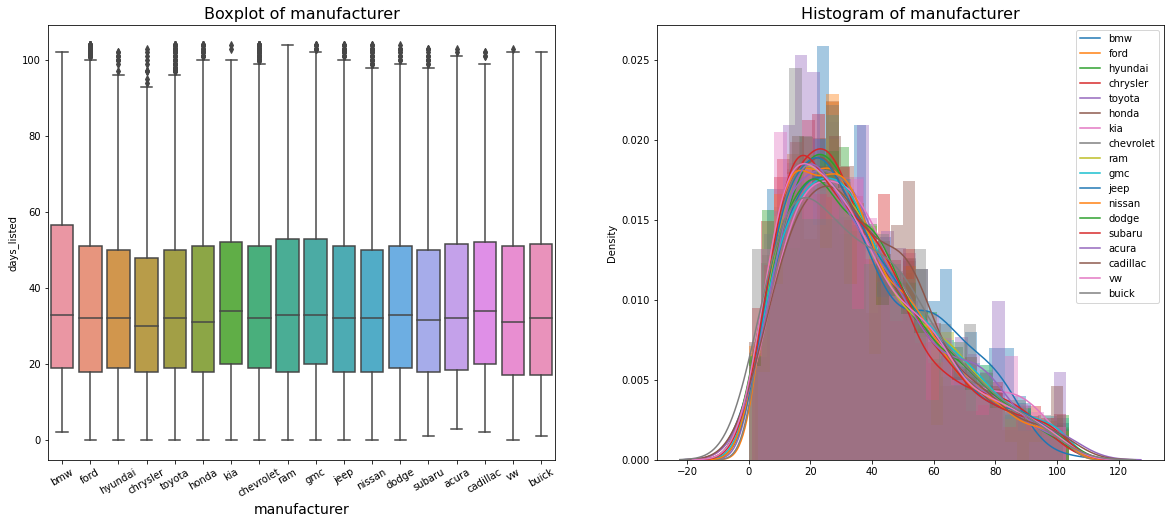

In [52]:
anova(clean_df, 'manufacturer', 'days_listed', 'Days Listed By Manufacturer Brand')

## Conclusion 
- g

# 4. What factors impact the price most? 
- We extablished that vehicle type has a significant effect size in relation to price
- Now we will take each of the two most popular types we detected at the previous stage and study the which numerical and categorical features are most correlated to price


Sedan-SUV Dataset Length: 22680


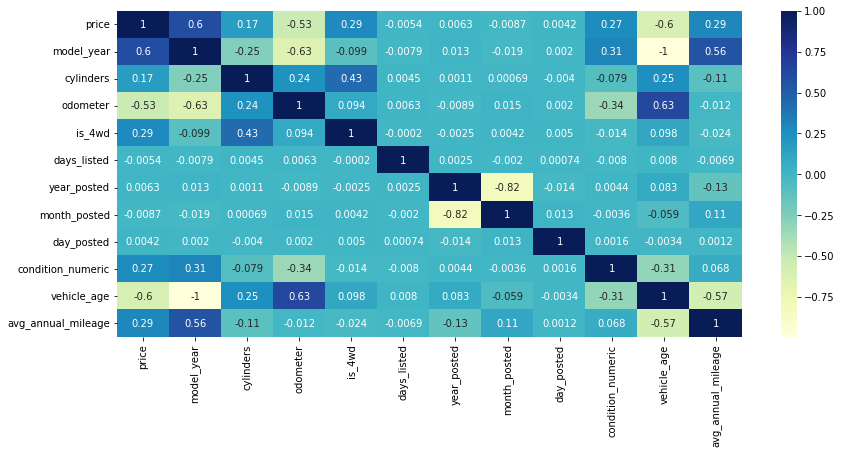


Trucks Dataset Length: 16640


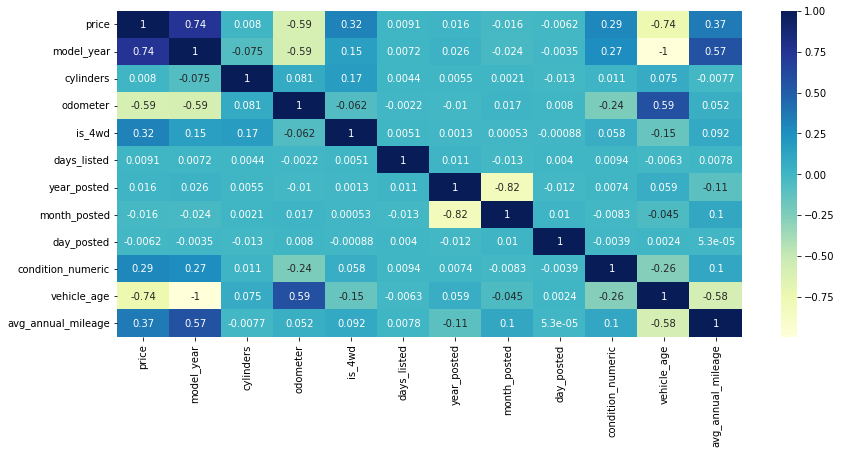


Other Dataset Length: 3252


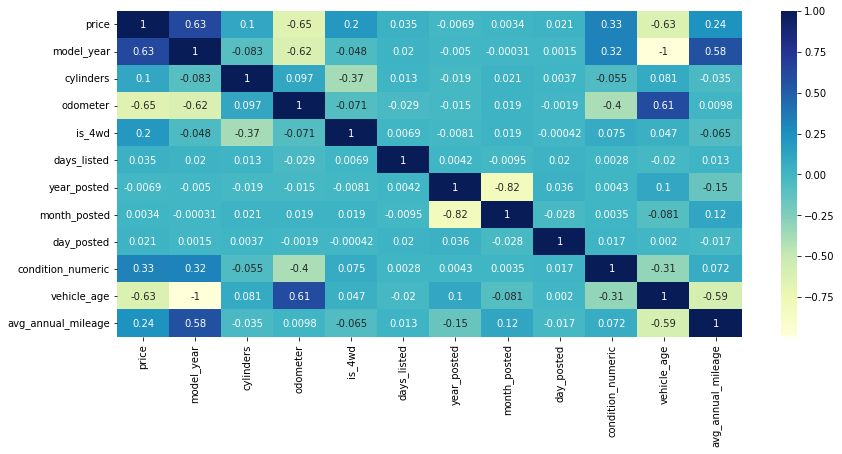

In [53]:
sedan_suv = clean_df[clean_df['type'].str.contains('sedan|suv')]
trucks = clean_df[clean_df['type'].str.contains('truck|pick')]
other = clean_df[clean_df['type'].str.contains('bus|van|offroad|wagon')]

print('Sedan-SUV Dataset Length:', len(sedan_suv))
plt.figure(figsize=(14,6))
sns.heatmap(sedan_suv.corr(), annot=True, color='blue', cmap="YlGnBu")
plt.show()
print()

# As comparison
print('Trucks Dataset Length:', len(trucks))
plt.figure(figsize=(14,6))
sns.heatmap(trucks.corr(), annot=True, color='blue', cmap="YlGnBu")
plt.show()
print()

print('Other Dataset Length:', len(other))
plt.figure(figsize=(14,6))
sns.heatmap(other.corr(), annot=True, color='blue', cmap="YlGnBu")
plt.show()

## Conclusion 
- For both Sedan and SUV vehicle age, odometer, and condition all have moderate correlation to price 
  - Sedan price has a slightly stronger correlation to all three features
  - SUV price has a stronger correlation to 4 wheel driver than Sewdan albeit slight weak correlation overall
- We can see that for both Sedan and SUV vehicle age, odometer, is_4wd, and condition have the highest correlation to vehicle price
- Lets dig into the nature of this correlation with some visualizations

Additional Note
- Trucks - 4 wheel drive has a stronger correlation to price for this category than others
- Other - Condition has a stronger correlation to price for this category than others


## Scatterplot with Linear Regression and Heteroscedasticity Test
### Sedan-SUV Price To Vehicle Age (Highest Correlation)


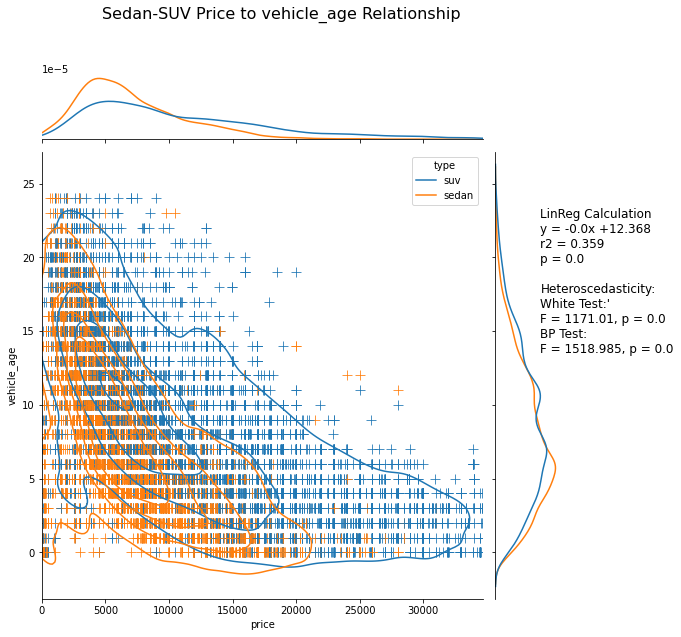

In [54]:
def jplot(df, col_b, label):
  m, b, r, p, err = stats.linregress(df['price'], df[col_b])
  x = range(df['price'].min(), df['price'].max())
  y = m*x+b

  model = ols(formula='price~'+col_b, data=df).fit()
  wLM_Stat, wLM_p, wF_Stat, wF_p = het_white(model.resid, model.model.exog)
  bpLM_Stat, bpLM_p, bpF_Stat, bpF_p = het_breuschpagan(model.resid, model.model.exog)

  textstr = 'LinReg Calculation\n'
  textstr += "y = " + str(round(m,3)) +"x +"+str(round(b,3))+'\n'
  textstr += "r2 = "+ str(round(r**2,3))+"\n"
  textstr += "p = "+str(round(p,3))+'\n\n'

  textstr += "Heteroscedasticity:\nWhite Test:'\n"
  textstr += 'F = '+str(round(wF_Stat,3))+', p = '+str(round(wF_p,3))+'\n'
  textstr += 'BP Test:\n'+'F = '+str(round(bpF_Stat,3))+', p = '+str(round(bpF_p,3))

  viz = sns.jointplot(x='price', y=col_b, marker="+", hue='type', s=100, data=df, height=8, ratio=6, marginal_kws=dict(fill=False))
  viz.plot_joint(sns.kdeplot, color="r", zorder=1, levels=5)
  viz.ax_marg_x.set_xlim(df['price'].min()-5, df['price'].max()+1)
  text = viz.fig.suptitle(label+' Price to '+col_b+' Relationship', fontsize=16, position=(0.5,1.1))
  plt.xlabel("Price", size=14)
  plt.ylabel(col_b, size=14)

  plt.text(0.95, 0.5, textstr, fontsize=12, transform=plt.gcf().transFigure)
  plt.show()

jplot(sedan_suv, 'vehicle_age', 'Sedan-SUV')

## Conclusion
- The cluster formed in the left of the graph is so tight and contains so many instances that the dispersion from datapoints in the right/lower-right is causing high high heteroscedasticity from both White and Breusch-Pagen tests 
- Higher heteroscedasticity appears to come from SUV types which is more dispersed especially at 5-15 age and 1000-12500 USD price range and is more clearly indicated by the KDE hist plats along the top and right edges of the plot
- Note I plotted a simple OLS linear regression and it fails to capture the data beyond the 15000 USD and above 17 years age due to the spread
- This feature alone is not great indicator of price and not the 0.63 correlation indicated by the pearson test which assumes homoscedasticity aka equal variance among label groups
- However it should be combined into an MLR algorithm


## SUV Price To Odometer (2nd Highest Correlation)
## Joinplot with KDE 


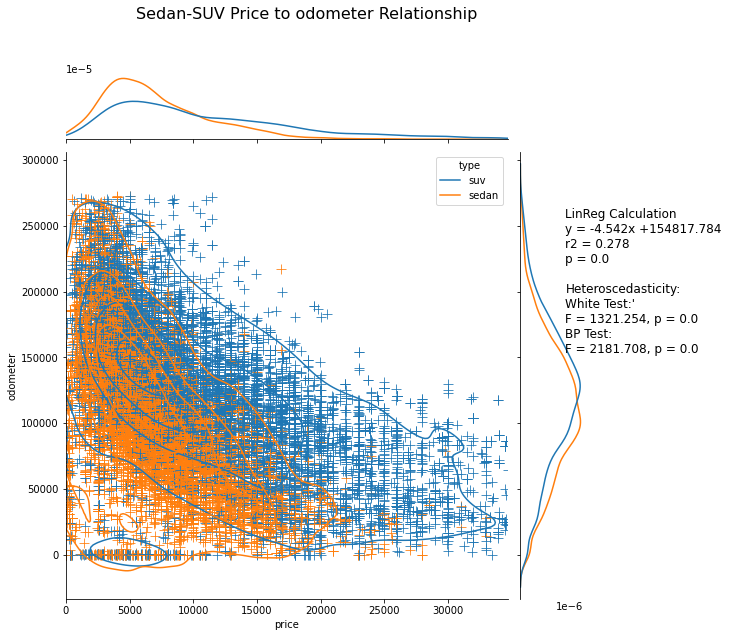

In [55]:
jplot(sedan_suv, 'odometer', 'Sedan-SUV')

## Conclusion
- Same pattern and same conclusion as above 
- However for this feature both sedan and SUV are contributing to the dispersion

In [56]:
# import plotly.express as px

# fig = px.scatter_3d(sedan_suv.sample(frac=0.5), x='vehicle_age', y='price', z='odometer', color='manufacturer', size_max=50, opacity=0.5)
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# fig.show()

## Paint Color To Price (ANOVA)
### Final Trim Removes Instances of Less Than 50 Labels

In [57]:
def ttest(df, col_a, col_b):
  groups = df[col_a].unique()
  ttests = []

  for i, g in enumerate(groups):
    for i2, g2 in enumerate(groups):
      if i2 > i:
        group1 = df[df[col_a]==g][col_b]
        group2 = df[df[col_a]==g2][col_b]

        t, p = stats.ttest_ind(group1, group2)

        ttests.append([g, g2, t.round(3), p.round(3)])
  
  ttest_df = pd.DataFrame(columns=[col_a+'_1', col_a+'_2', 't-stat', 'p-value'], data=ttests).sort_values(by='t-stat', ascending=False)
  p_threshold = 0.5 /len(ttests)

  return ttest_df, p_threshold

In [58]:
def anova(df, col_a, col_b, title):
  types = df[col_a].unique()
  anovas = []

  for typ in types:
    anovas.append(df[df[col_a] == typ][col_b])
  
    f, p = stats.f_oneway(*anovas)

  
  anovatextstr = f'ANOVA Test \nF-Stat:{f.round(3)}\np-value{p.round(3)}'
  print(anovatextstr,'\n')
  return boxplots(df, col_a, col_b, title,  'abc', 25)

ANOVA Test 
F-Stat:1181.038
p-value0.0 



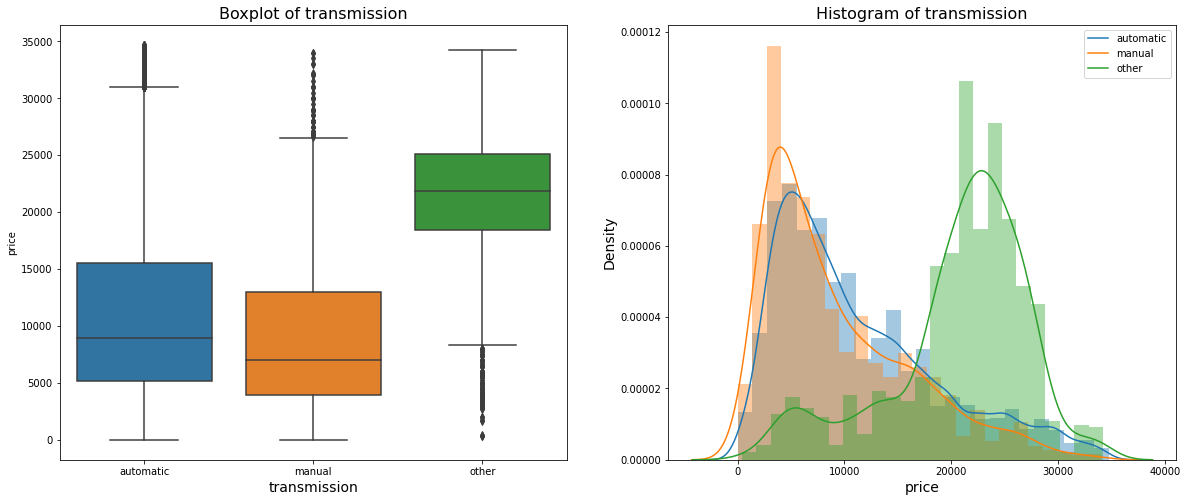


Adjusted p-value threshold 0.1667
transmission_1 transmission_2  t-stat  p-value
     automatic         manual  12.195      0.0
     automatic          other -46.248      0.0
        manual          other -50.637      0.0


In [60]:
sedan_suv = final_trim(sedan_suv, 'transmission')

anova(sedan_suv, 'transmission', 'price', 'Sedan-SUV Price By transmission')

ttests_df, p_thresh = ttest(sedan_suv, 'transmission', 'price')
print("Adjusted p-value threshold",round(p_thresh, 4))
print(ttests_df.head(3).to_string(index = False))

In [61]:
sedan_suv.groupby('transmission')[['price', 'cylinders', 'odometer', 'is_4wd', 'days_listed', 'vehicle_age']].mean().round(2)

,price,cylinders,odometer,is_4wd,days_listed,vehicle_age
transmission,,,,,,
automatic,11205.47,6.06,118324.38,0.49,36.71,8.37
manual,9242.23,5.54,127741.29,0.42,36.35,11.62
other,20673.78,6.43,56142.56,0.43,36.27,3.77


In [62]:
print('Other Transmission Vehicle Type and Count:\n', sedan_suv[sedan_suv['transmission'] == 'other']['type'].value_counts())

Mean Manual Transmission Price: 9242.23 

Other Transmission Vehicle Type and Count:
 pickup         600
coupe          545
suv             91
truck           73
sedan           67
wagon           28
hatchback       14
van              4
other            2
convertible      1
mini-van         1
Name: type, dtype: int64


In [63]:
sedan_suv[sedan_suv['transmission'] == 'other']['manufacturer'].value_counts()[:5]

ford         485
chevrolet    363
nissan       358
jeep          62
toyota        41
Name: manufacturer, dtype: int64

## Conclusion
- Clearly the other category is the most expensive and a clear indicator of price
- Other is slightly left skewed and the mean will be lower than the median
- Automatic and manual are right skewed and the mean wwith be higher than the median
- Unclear what the other category includes but as pickup trucks and coupes contribute the most it is to be a continuously variable transmission, semi-automatic, or dual-clutch transmissions
- Vehicles with 'Other' transmission labels also have lower odometer counts
- Manual transmissions are the cheapest, oldest, and have the highest odometer readings


## Paint Color To Price

ANOVA Test 
F-Stat:111.367
p-value0.0 

T-tests below adjusted p-value threshold 0.0064

T-test Results Postivie 5
paint_color_1 paint_color_2  t-stat  p-value
        white        silver  21.113      0.0
        white          blue  20.964      0.0
        white         green  19.537      0.0
        black          blue  18.475      0.0
        black        silver  18.269      0.0

T-test Results Negative 5
paint_color_1 paint_color_2  t-stat  p-value
       silver        yellow  -9.699      0.0
         blue        yellow -10.228      0.0
          red         black -11.947      0.0
        mixed         white -12.109      0.0
        green        yellow -12.736      0.0


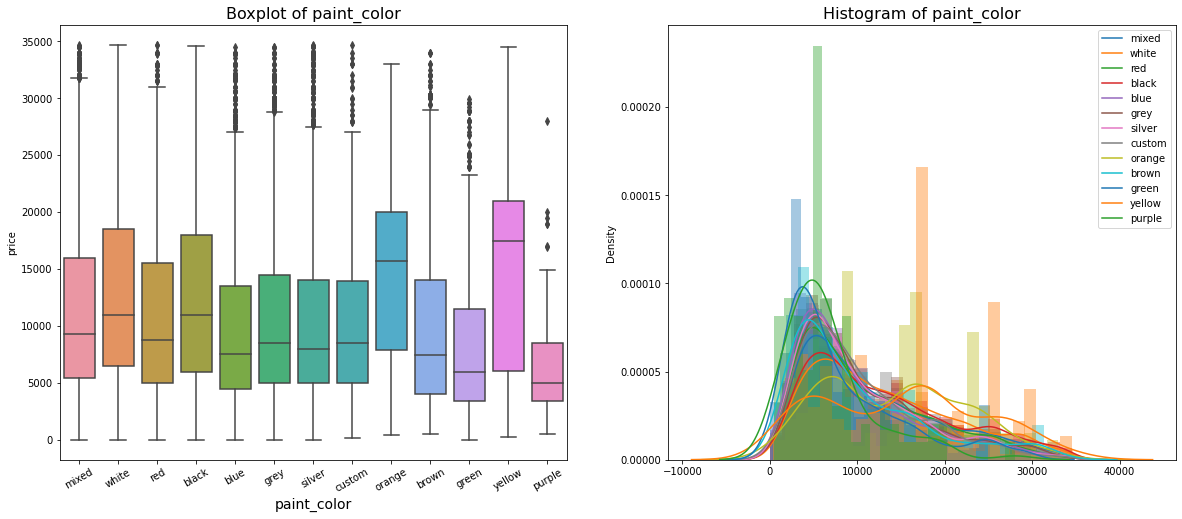

In [66]:
sedan_suv = final_trim(sedan_suv, 'paint_color')
anova(sedan_suv, 'paint_color', 'price', 'Sedan-SUV Price By paint color')

ttests_df, p_thresh = ttest(sedan_suv, 'paint_color', 'price')
print("T-tests below adjusted p-value threshold:",round(p_thresh, 4))
print()
print('T-test Results Postivie 5')
print(ttests_df.head(5).to_string(index = False))
print()
print('T-test Results Negative 5')
print(ttests_df.tail(5).to_string(index = False))

In [68]:
sedan_suv['paint_color'].value_counts()

white     8756
mixed     8271
black     6770
silver    5757
grey      4603
blue      4037
red       3904
green     1271
brown     1092
custom     978
yellow     220
orange     201
purple      89
Name: paint_color, dtype: int64

In [74]:
sedan_suv[sedan_suv['paint_color'] == 'white']['type'].value_counts()

truck          3156
suv            1762
pickup         1593
sedan          1406
wagon           160
coupe           160
mini-van        153
van             139
hatchback       116
convertible      34
other            34
offroad          26
bus              16
Name: type, dtype: int64

In [67]:
sedan_suv.groupby('paint_color')[['price', 'cylinders', 'odometer', 'is_4wd', 'days_listed', 'vehicle_age']].mean().round(2)

,price,cylinders,odometer,is_4wd,days_listed,vehicle_age
paint_color,,,,,,
black,12768.63,6.07,109157.18,0.51,37.06,7.43
blue,9881.86,5.81,120889.96,0.46,37.04,9.03
brown,9987.82,5.93,128205.70,0.49,37.46,9.97
custom,10271.30,6.02,126277.51,0.48,34.78,9.62
green,8331.64,5.98,133845.65,0.60,37.45,12.25
grey,10591.34,5.72,114286.84,0.43,36.60,7.87
mixed,11520.13,6.05,115955.89,0.48,36.63,8.30
orange,14167.01,6.12,106777.76,0.64,36.14,8.72
purple,6763.06,5.78,141190.61,0.53,39.66,11.51


## Conclusion
- Paint color is a statisically significant feature when assessing vehicle price
- White black and yellow are the most expensive and most significant predictors of price
- White black and yellow are usually around 7.5 years while other colors vary from 8-12 years old
- Orange is also expensive however its sample size it too small to draw conclusions about population means
- A large subset of Trucks, SUVs, and Pickups in this dataset is whats driving the price of this vehicle color up


## Fuel To Price

ANOVA Test 
F-Stat:837.583
p-value0.0 



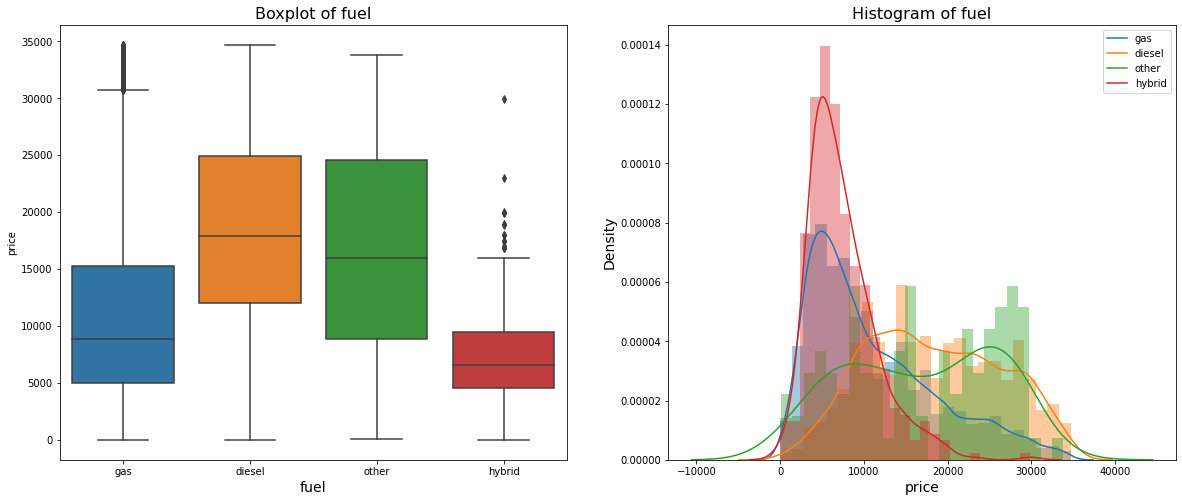


T-tests below adjusted p-value threshold 0.08

T-test Results Positive 5
 fuel_1  fuel_2  t-stat  p-value
 diesel  hybrid  26.270    0.000
  other  hybrid  15.471    0.000
    gas  hybrid   9.230    0.000
 diesel   other   1.847    0.065
    gas   other  -7.748    0.000


In [70]:
sedan_suv = final_trim(sedan_suv, 'fuel')
anova(sedan_suv, 'fuel', 'price', 'Sedan-SUV Price By fuel')

ttests_df, p_thresh = ttest(sedan_suv, 'fuel', 'price')
print("T-tests below adjusted p-value threshold",round(p_thresh,2))
print()
print('T-test Results Positive 5')
print(ttests_df.head(5).to_string(index = False))


In [71]:
sedan_suv.groupby('fuel')[['price', 'cylinders', 'odometer', 'is_4wd', 'days_listed', 'vehicle_age']].mean().round(2)

,price,cylinders,odometer,is_4wd,days_listed,vehicle_age
fuel,,,,,,
diesel,18320.14,7.18,149692.73,0.82,36.98,9.89
gas,10992.40,5.99,114851.94,0.46,36.68,8.30
hybrid,7428.14,4.20,122658.57,0.04,34.61,8.55
other,16820.56,7.03,90351.30,0.55,36.12,5.91


In [75]:
sedan_suv[sedan_suv['fuel'] == 'hybrid']['type'].value_counts()

hatchback    207
sedan        141
suv           15
truck          6
coupe          6
pickup         4
other          2
mini-van       1
wagon          1
Name: type, dtype: int64

In [78]:
sedan_suv[sedan_suv['fuel'] == 'diesel']['type'].value_counts()

truck        1643
pickup        744
sedan         197
suv            40
wagon          15
other          11
coupe           4
van             2
hatchback       1
Name: type, dtype: int64

## Conclusion
- Fuel type is another significant predictor of price
- Deisel and Hybrid are the most statisically signficant fuel types to predict price 
- Again we see trucks and pick ups driving the price of these vehicles up
- Interestingly we see a similar proportion of sedans in the top 3 vehicles of both types

## Manufacturer to Price

ANOVA Test 
F-Stat:275.275
p-value0.0 

T-tests below adjusted p-value threshold: 0.0033

T-test Results Postivie 5
manufacturer_1 manufacturer_2  t-stat  p-value
           ram         nissan  35.086      0.0
          ford          honda  30.747      0.0
           ram             vw  29.673      0.0
           ram          dodge  28.908      0.0
           ram         subaru  28.499      0.0

T-test Results Negative 5
manufacturer_1 manufacturer_2  t-stat  p-value
       hyundai            ram -34.054      0.0
        toyota            ram -34.760      0.0
         honda      chevrolet -36.195      0.0
         honda            gmc -36.702      0.0
         honda            ram -50.188      0.0


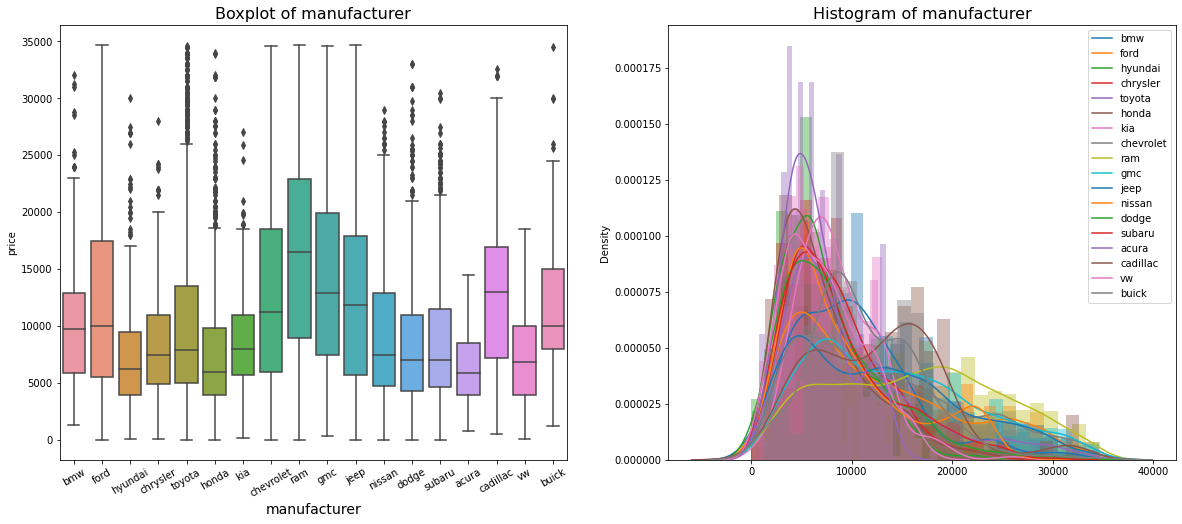

In [80]:
sedan_suv = final_trim(sedan_suv, 'manufacturer')

anova(sedan_suv, 'manufacturer', 'price', 'Sedan-SUV Price By Manufacturer')

ttests_df, p_thresh = ttest(sedan_suv, 'manufacturer', 'price')
print("T-tests below adjusted p-value threshold:",round(p_thresh,4))
print()
print('T-test Results Postivie 5')
print(ttests_df.head(5).to_string(index = False))
print()
print('T-test Results Negative 5')
print(ttests_df.tail(5).to_string(index = False))

In [82]:
sedan_suv[sedan_suv['manufacturer'] == 'ram']['type'].value_counts()

truck      1723
pickup      943
van           7
other         7
suv           2
wagon         2
offroad       1
Name: type, dtype: int64

In [83]:
sedan_suv[sedan_suv['manufacturer'] == 'honda']['type'].value_counts()

sedan          1521
suv             842
coupe           329
mini-van        300
van             107
wagon            88
hatchback        26
other            15
truck             6
convertible       1
offroad           1
Name: type, dtype: int64

## Conclusion
- Is the second weakest pridictor of price the large number of label groups means that the differences are less apparent 
- Within the group of manufacturers its clear Ram - a truck, pickup manufacturer is the most expensive while Honda is the cheapest
- Interestingly though Honda produces SUVs, Vans and some other large behicles but retains a relativly low price overall

# Overall Conclusion

**Preprocessing**
  - Overall post processing we lost only 11% of our data (closer to 12% when labels with fewer than 50 instances are trimmed) and almost all of the feature means and medians fell withing a +/-10% of each other
  - We need to investigate the missing paint color entries with Crankshaft seperatly
  - The vehicle type parameter of Crankshaft marketplace appears to allow users to assign an incorrect vehicle types - example there is no official Ford F150 being listed as a sedan. This field should be corrected and the list of types limited to official vehicle types associated with the users vehicle model

**Numeric Outlier detection**
 - Outliers were detected and removed in Price, Odometer, Days Listed, Vehicle Age using the IQR 1.5 rule
 - We used personal judgement to remove lower threshold outliers which consisted of zero odometer values for non-new vehicles and 1 USD vehicles. Both of which are caused by various reasons listed above but generally do not reflect the population trends so we removed them

**Categorical Outlier Detection**
  - When graphing categorical impact on features like Price and Days Listed we removed labels with fewer than 50 entries so as not to mis-interperet a skewed distribution which is not reflective of the population trends

**Typical Ad Lifetimes**
  - The average ad lifetime between all vehicle types is between 38 - 44 days
  - Buses take the longest time on average to sell
  - Days listed is right skewed for all types except bus

**Top Numeric Features for Days Listed**
- Overall no numeric features have a significant effect size or correlation to days_listed

**Top Categorical Fearures For Days Listed**
- Overall there is only a slight effect size on categorical features paint color, manufacturer, fuel type
- High p-value for fuel, transmission, and paint_color indicating potential random chance distributions

**Ad Lifetime Note**
  - There is a greater effect size when the dataset is split into shorter (Q1) and longer (Q3) ad lifetimes
  - However this was beyond the scope of the brief and the drew out the notebook so I removed it but it would be worth a second look

**Top Numeric Features for Price**
- We can see that numeric the feature which impact price for both Sedan and SUV vehicle are in descending order age, odometer, is_4wd, condition, cylinder have the highest correlation to vehicle price
  - The relationship is linear however the high pearson r is misleading as there is a high level of dispersion and heteroscedasticity along the x-axis meanign this featrure alone is not a good predictor of price above 15000 USD and vehicles older than 17 

**Top Categorical Features For Price**

**Transmission**
- Transmission has the highest F-stat: 1181.038
- The "other" label is the most expensive and a clear indicator of vehicle price
  - Unclear what the other category includes but as pickup trucks, coupes, and SUVs contribute the most it is to be a continuously variable transmission, semi-automatic, or dual-clutch transmissions
  - Vehicles with 'Other' transmission labels also have lower odometer counts
- Manual transmissions are the cheapest but also generally the oldest, and have the highest odometer readings

**Paint Color**
- Paint color is the least significant categorical predictor of price F-Stat: 111.367
- However it is clear that white, black, and yellow are the most expensive and most significant predictors of high price
- White black and yellow are usually younger too around 7.5 years while other colors vary from 8-12 years old
- Orange is also expensive however its sample size it too small to draw conclusions about population means
- A large subset of Trucks, SUVs, and Pickups in this dataset is whats driving the price of this vehicle color up

**Fuel Type**
- Fuel type is another significant predictor of price (F-stat: 837.583) with hybrid being the cheapest costing on average 7428 USD
- Deisel and Hybrid are the most statisically signficant opposing fuel types to predict price 
- Again we see trucks and pick ups driving the price of these vehicles up
- Interestingly we see a similar proportion of sedans in the top 3 vehicles of both types


**Manufacturer**
- Is the second weakest pridictor of price the large number of label groups means that the differences are less apparent 
- Within the group of manufacturers its clear Ram - a truck, pickup manufacturer is the most expensive while Honda is the cheapest
- Interestingly though Honda produces SUVs, Vans and some other large behicles but retains a relativly low price overall


